In [1]:
%store -d df
%store -d families
%store -d ratings
%store -d ratings_train
%store -d ratings_test
%store -d train
%store -d test
%store -d pr_sim
%store -d pred_df
%store -d output
%store -d recommendations

In [2]:
import numpy as np
import pandas as pd
import random
from scipy.stats import pearsonr
from math import isnan
import time
import networkx as nx
import re

In [3]:
global_time = time.time()
# Read OLO
df=pd.read_excel("../../OLOORDERS.xlsx")

df.columns = [u'WEB', u'CDis', u'Agen come', u'GVen', u'cod_venta', u'Cliente', 
              u'Nombre', u'Posición', u'Fecha crea', u'Producto', u'Descripcion', 
              u'Cantidad', u'UM', u'Venta neta', u'Moneda']

df=df.drop([u'WEB', u'CDis', u'Agen come', u'GVen', u'Nombre'], axis=1)

df.head()

,cod_venta,Cliente,Posición,Fecha crea,Producto,Descripcion,Cantidad,UM,Venta neta,Moneda
0,101303229,40570,10,2016-10-31,000001228,"B.L/C PET BL. 210,0X297,0 20H",1,UN,11.45,EUR
1,101303229,40570,20,2016-10-31,000001270,"C.I/L/C 70,0X 25,4 100H",1,UN,9.74,EUR
2,101303230,13995,10,2016-10-31,000012769,B.GOMA EVA BLANCO 400X600X2MM 5H,1,UN,1.74,EUR
3,101303230,13995,20,2016-10-31,000012768,B.GOMA EVA NEGRO 400X600X2MM 5H,1,UN,1.74,EUR
4,101302933,105277,10,2016-10-28,000010532,"C.MULTI3 210,0X148,0 500H",6,UN,96.00,EUR


In [4]:
#Read families
families=pd.read_csv("../../Dades/Asignacion_productos.csv")
families = families.drop(families.columns[[0, 1, 3, 4, 5, 6, 7, 9, 10]], 1)
families.columns=["Area", "Material"]
print families.shape
families.head()

(2657, 2)


,Area,Material
0,143,000001776
1,143,000001777
2,143,000001778
3,143,000001781
4,143,000001782


In [5]:
# Intersect products from OLO and families
def intersect(a, b):
    return list(set(a) & set(b))

ProductsList=np.unique(np.array(df["Producto"]))
ProductsList_intersect=intersect(ProductsList, families["Material"].values)
df=df.loc[df['Producto'].isin(ProductsList_intersect)]

In [6]:
# Groupby Cliente and ProductsList
gr=df.groupby(["Cliente"])["Producto"].apply(list)
prod=pd.DataFrame(gr)
ProductsList=np.unique(np.array(df["Producto"]))

In [7]:
# Create ratings
start_time = time.time()
ratings=pd.DataFrame(index=prod.index, columns=ProductsList)
ratings=ratings.fillna(0)
for i in np.arange(len(prod)):
    for j in np.arange(len(prod[prod.index==prod.index[i]]["Producto"].values[0])):
        ratings.loc[prod.index[i], prod[prod.index==prod.index[i]]["Producto"].values[0][j]]+=1
print("Minutes: " + str((time.time() - start_time)/60.0))

# Normalize ratings
start_time = time.time()
for user in ratings.index:
    ratings.loc[user]=ratings.loc[user]/ratings.loc[user].sum()
print("Minutes: " + str((time.time() - start_time)/60.0))

Minutes: 4.96983081897
Minutes: 0.267635567983


In [8]:
#Train and test index
np.random.seed(40)
no_null_index={}
for item in ratings.columns:
     no_null_index[item]=ratings[item][ratings[item]!=0.0].index.tolist()

train_index={}
test_index={}
for item in no_null_index.keys():
    test_index[item]=np.random.choice(no_null_index[item], int(0.2*len(no_null_index[item])))
    train_index[item]=list(set(no_null_index[item])-set(test_index[item]))

In [9]:
# Create ratings train
start_time = time.time()
ratings_train=pd.DataFrame(index=prod.index, columns=ProductsList)
ratings_train=ratings_train.fillna(0.0)
for item in train_index.keys():
    for user in train_index[item]:
        ratings_train[item][user]=ratings[item][user]
print("Minutes: " + str((time.time() - start_time)/60.0))

# Add area columns
start_time = time.time()
for area in families["Area"].unique():
    area_name="A"+str(area)
    ratings_train[area_name]=0.0
print("Minutes: " + str((time.time() - start_time)/60.0))

# Add area ratings_train
start_time = time.time()
for user in ratings_train.index:
    user_ratings_train=ratings_train.loc[user][ratings_train.loc[user]!=0.0]
    for product in user_ratings_train.index:
        area_aux="A"+str(families[product==families["Material"]]["Area"].values[0])
        ratings_train.loc[user][area_aux]=ratings_train.loc[user][area_aux]+user_ratings_train.loc[product]
print("Minutes: " + str((time.time() - start_time)/60.0))

Minutes: 1.45533071756
Minutes: 0.001646733284
Minutes: 3.64028053284


In [10]:
# Create ratings test
start_time = time.time()
ratings_test=pd.DataFrame(index=prod.index, columns=ProductsList)
ratings_test=ratings_test.fillna(0.0)
for item in test_index.keys():
    for user in test_index[item]:
        ratings_test[item][user]=ratings[item][user]
print("Minutes: " + str((time.time() - start_time)/60.0))

# Add area columns
start_time = time.time()
for area in families["Area"].unique():
    area_name="A"+str(area)
    ratings_test[area_name]=0.0
print("Minutes: " + str((time.time() - start_time)/60.0))

# Add area ratings_test
start_time = time.time()
for user in ratings_test.index:
    user_ratings_test=ratings_test.loc[user][ratings_test.loc[user]!=0.0]
    for product in user_ratings_test.index:
        area_aux="A"+str(families[product==families["Material"]]["Area"].values[0])
        ratings_test.loc[user][area_aux]=ratings_test.loc[user][area_aux]+user_ratings_test.loc[product]
print("Minutes: " + str((time.time() - start_time)/60.0))

Minutes: 0.340278653304
Minutes: 0.00156863530477
Minutes: 0.792143150171


In [11]:
# Add area columns
start_time = time.time()
for area in families["Area"].unique():
    area_name="A"+str(area)
    ratings[area_name]=0.0
print("Minutes: " + str((time.time() - start_time)/60.0))

# Add area ratings
start_time = time.time()
for user in ratings.index:
    user_ratings=ratings.loc[user][ratings.loc[user]!=0.0]
    for product in user_ratings.index:
        area_aux="A"+str(families[product==families["Material"]]["Area"].values[0])
        ratings.loc[user][area_aux]=ratings.loc[user][area_aux]+user_ratings.loc[product]
print("Minutes: " + str((time.time() - start_time)/60.0))

Minutes: 0.00183241764704
Minutes: 4.45725421508


In [12]:
# Create train
train_list=[]
train_cont=[]

for user in ratings_train.index:
    #aux=intersect(ratings_train.loc[user][ratings_train.loc[user]!=0.0].index, train_prod)
    aux=list(ratings_train.loc[user][ratings_train.loc[user]!=0.0].index)
    train_list.append(aux)
    train_cont.append(len(aux))

train=pd.DataFrame(index=ratings_train.index, columns=["items", "#items"])
train["items"]=train_list
train["#items"]=train_cont

# Create test
test_list=[]
test_cont=[]
for user in ratings_test.index:
    #aux=intersect(ratings.loc[user][ratings.loc[user]!=0.0].index, test_prod)
    aux=list(ratings_test.loc[user][ratings_test.loc[user]!=0.0].index)
    test_list.append(aux)
    test_cont.append(len(aux))

test=pd.DataFrame(index=ratings_test.index, columns=["items", "#items"])
test["items"]=test_list
test["#items"]=test_cont

test=test.loc[intersect(train.index, test.index)]

In [13]:
# Crate a Graph
G=nx.Graph()
G.add_nodes_from(ratings_train.index.tolist())
G.add_nodes_from(ratings_train.columns.tolist())

In [14]:
# Compute mean ratings_train
mean_ratings=ratings_train[ratings_train!=0.0].mean().mean()
print mean_ratings
if mean_ratings<0.0001:
    mean_ratings=0.0001
print mean_ratings
# Coment to compuete mean ratings
#mean_ratings=0.0

0.00754512219129
0.00754512219129


In [15]:
# Take values bigger than mean ratings, remove 0.0
df_aux=ratings_train[ratings_train!=0.0]
df_aux=df_aux[df_aux>mean_ratings]
df_aux.head()

,000000001,000000002,000000003,000000004,000000005,000000006,000000007,000000008,000000010,000000011,...,A345,A351,A353,A354,A355,A356,A357,A358,A359,A360
Cliente,,,,,,,,,,,,,,,,,,,,,
95,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.016000,0.032000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10131,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.011824,0.016892,NaN,0.010135,NaN,NaN,NaN,NaN,NaN,NaN
10188,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10262,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10362,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
# Create edges
for user in df_aux.index:
    no_null_ratings=ratings_train.loc[user][df_aux.loc[user].notnull()]
    for item in no_null_ratings.index:
        G.add_edge(user, item, weight=no_null_ratings.loc[item]/no_null_ratings.sum())

In [17]:
df_aux=df_aux.transpose()

In [ ]:
#Create similarity matrix
start_time = time.time()
start_time_diff = time.time()

pr_dict={}
cont_global=0
for user in df_aux.index:
    cont_global=cont_global+1
    aux_G=G.copy()
    n=len(G.nodes())
    no_null_ratings=ratings_train[user][df_aux.loc[user].notnull()]
    null_items=[item for item in ratings_train.index.tolist() if item not in no_null_ratings.index]
    other_users=[u for u in ratings_train.columns.tolist() if u not in [user]]
    # Edges no_null_item - null_item
    for item1 in no_null_ratings.index:
        for item2 in null_items:
            aux_G.add_edge(item1, item2, weight=1./n)
    # Edges no_null_item - no_null_item (no repeat)
    cont=1
    for item1 in no_null_ratings.index:
        for item2 in no_null_ratings.index[:cont]:
            aux_G.add_edge(item1, item2, weight=1./n)
            cont=cont+1
    # Edges no_nul_item - other_users
    for item in no_null_ratings.index:
        for u in other_users:
            if item in aux_G[u].keys():
                aux_G[u][item]['weight']=aux_G[item][u]['weight']+1./n
            else:
                aux_G.add_edge(item, u, weight=1./n)
    pr=nx.pagerank(aux_G)
    pr_dict[user]=pr
    if cont_global%100==0:
        print cont_global
        print("--- %s seconds ---" % (time.time() - start_time_diff))
        start_time_diff = time.time()

print("Minutes: " + str((time.time() - start_time)/60.0))

In [ ]:
# Pagerank user similarity (no symmetric)
pr_sim=pd.DataFrame.from_dict(pr_dict, orient='index')[df_aux.index]

In [18]:
pr_sim=pd.read_csv("pr_sim_item.csv")
pr_sim=pr_sim.drop("Unnamed: 0", axis=1)
pr_sim.index=pr_sim.columns
pr_sim.head()

/home/jps/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,000000001,000000002,000000003,000000004,000000005,000000006,000000007,000000008,000000010,000000011,...,A345,A351,A353,A354,A355,A356,A357,A358,A359,A360
000000001,0.000174,0.000042,0.000123,0.000235,0.000056,0.000059,0.000209,0.000248,0.000037,0.000041,...,0.000611,0.000908,0.000088,0.001260,0.000035,0.00021,0.000177,0.000964,0.000170,0.000144
000000002,0.000057,0.000065,0.000121,0.000240,0.000056,0.000059,0.000201,0.000130,0.000037,0.000041,...,0.000610,0.000906,0.000088,0.001289,0.000035,0.00019,0.000177,0.000939,0.000163,0.000144
000000003,0.000058,0.000043,0.000240,0.000233,0.000056,0.000059,0.000211,0.000135,0.000037,0.000042,...,0.000607,0.000899,0.000087,0.001262,0.000036,0.00019,0.000180,0.000939,0.000166,0.000142
000000004,0.000059,0.000046,0.000124,0.000519,0.000056,0.000059,0.000215,0.000134,0.000037,0.000042,...,0.000605,0.000896,0.000087,0.001273,0.000036,0.00019,0.000191,0.000932,0.000163,0.000142
000000005,0.000058,0.000042,0.000121,0.000229,0.000100,0.000059,0.000201,0.000130,0.000037,0.000041,...,0.000609,0.000905,0.000088,0.001263,0.000035,0.00019,0.000180,0.000955,0.000169,0.000143


In [24]:
# Predict function
def predict_pr(df, sim_df, user, item, k=10, tol=0.0):
    #aux=sim_df.loc[user][sim_df.loc[user].notnull()==True]
    #auxx=sim_df[user][sim_df[user].notnull()==True]
    #sim_sorted=aux.append(auxx).sort_values(ascending=False)
    sim_sorted=sim_df.loc[user].sort_values(ascending=False)
    posible_users=df.index[df[item]!=0.0]
    posible_users=list(set(posible_users)-set([user]))
    if len(posible_users)<k:
        k=len(posible_users)
    sim_sorted=sim_sorted.loc[posible_users].sort_values(ascending=False)
    top_k_sim=sim_sorted[:k]
    top_k_sim=top_k_sim[top_k_sim>=tol]
    k=top_k_sim[top_k_sim>=tol].count()
    if k==0:
        return 0.0
    pred=0.0
    #div=1.e-16
    div=0.0
    for i in np.arange(k):
        #if df[df.index==top_k_sim.index[i]][item].values[0]!=99.0:
        aux_pred=top_k_sim.iloc[i]*df[df.index==top_k_sim.index[i]][item].values[0]
        pred=pred+aux_pred
        div=div+top_k_sim.iloc[i]
    if div==0.0:
        div=1.e-16
    pred=pred/div
    return pred

In [25]:
# Predict function with mean
def predict_pr_with_mean(df, sim_df, user, item, k=10, tol=0.0):
    #aux=sim_df.loc[user][sim_df.loc[user].notnull()==True]
    #auxx=sim_df[user][sim_df[user].notnull()==True]
    #sim_sorted=aux.append(auxx).sort_values(ascending=False)
    sim_sorted=sim_df.loc[user].sort_values(ascending=False)
    posible_users=df.index[df[item]!=0.0]
    posible_users=list(set(posible_users)-set([user]))
    if len(posible_users)<k:
        k=len(posible_users)
    sim_sorted=sim_sorted.loc[posible_users].sort_values(ascending=False)
    top_k_sim=sim_sorted[:k]
    top_k_sim=top_k_sim[top_k_sim>=tol]
    k=top_k_sim[top_k_sim>=tol].count()
    if k==0:
        return 0.0
    pred=0.0
    #div=1.e-16
    div=0.0
    for i in np.arange(k):
        #if df[df.index==top_k_sim.index[i]][item].values[0]!=99.0:
        v=top_k_sim.index[i]
        v_mean=df.loc[v][df.loc[v]!=99.0].mean()
        aux_pred=top_k_sim.iloc[i]*(df[df.index==top_k_sim.index[i]][item].values[0])
        pred=pred+aux_pred
        div=div+top_k_sim.iloc[i]
    u_mean=df.loc[user][df.loc[user]!=99.0].mean()
    if div==0.0:
        div=1.e-16
    pred=u_mean+pred/div
    return pred

In [55]:
# Predict function
def predict_pr(df, sim_df, user, item, k=10, tol=0.0):
    sim_sorted=sim_df.loc[item].sort_values(ascending=False)
    posible_users=df.columns[df.loc[user]!=0.0]
    posible_users=list(set(posible_users)-set([user]))
    if len(posible_users)<k:
        k=len(posible_users)
    sim_sorted=sim_sorted.loc[posible_users].sort_values(ascending=False)
    top_k_sim=sim_sorted[:k]
    top_k_sim=top_k_sim[top_k_sim>=tol]
    k=top_k_sim[top_k_sim>=tol].count()
    if k==0:
        return 0.0
    pred=0.0
    #div=1.e-16
    div=0.0
    for i in np.arange(k):
        aux_pred=top_k_sim.iloc[i]*df[top_k_sim.index[i]][user]
        pred=pred+aux_pred
        div=div+top_k_sim.iloc[i]
    if div==0.0:
        div=1.e-16
    pred=pred/div
    return pred

In [66]:
# Predict matrix
k_candidates=[5,10,15,20]
best_k=0
best_mae=np.inf
for k in k_candidates:
    print "k = " + str(k)
    start_time = time.time()
    pred_df = pd.DataFrame(index=test.index, columns=ratings_test.columns)
    evaluation=[]
    for user in test.index:
        items=test["items"].loc[user]
        for item in items:
            pred=predict_pr(ratings_test, pr_sim, user, item, k)
            diff=abs(pred-ratings_test[item][user])
            evaluation_row= [user, item, pred, ratings_test[item][user], diff]
            evaluation.append(evaluation_row)
            pred_df[item][user]=pred
    print("Minutes: " + str((time.time() - start_time)/60.0))

    evaluation_df=pd.DataFrame(evaluation, columns=["user", "item", "predict", "real", "diff"])

    print "MAE: " + str(evaluation_df["diff"].mean())
    
    if evaluation_df["diff"].mean()<best_mae:
        best_k=k
        best_mae=evaluation_df["diff"].mean()

    #MAE users with 20 or less ratings

    users_less_ratings=[]
    for u in ratings_test.index:
        aux=ratings_test.loc[u].value_counts()
        n=aux[aux.index!=0.0].sum()
        if n<=20:
            users_less_ratings.append(u)

    mae_less_ratings=[]
    for u in users_less_ratings:
        if len(evaluation_df[evaluation_df["user"]==u]["diff"])>0:
            mae_less_ratings.append(evaluation_df[evaluation_df["user"]==u]["diff"].mean())

    print "MAE with 20 or less ratings: " + str(np.mean(mae_less_ratings))
    evaluation_df.to_csv("../../Evaluation/evaluation_test_MAE_PageRank_item_based_k=" + str(k) + ".csv", index=False)
print "Best k = " + str(best_k) + " with MAE = " + str(best_mae)

k = 5
Minutes: 5.52711033424
MAE: 0.011702976189
MAE with 20 or less ratings: 0.0182198532022
k = 10
Minutes: 6.78998500109
MAE: 0.0104517169905
MAE with 20 or less ratings: 0.0178252781951
k = 15
Minutes: 8.12397413254
MAE: 0.00989441935704
MAE with 20 or less ratings: 0.017758646711
k = 20
Minutes: 9.65311636527
MAE: 0.00957778757434
MAE with 20 or less ratings: 0.0177499094339
Best k = 20 with MAE = 0.00957778757434


In [67]:
#Identify familes
r = re.compile("^A")
area_colnames = filter(r.match, ratings.columns)

In [68]:
# Predict matrix

start_time = time.time()
pred_df = pd.DataFrame(index=ratings.index, columns=area_colnames)
cont=0
for user in ratings.index:
    cont=cont+1
    if cont%100==0:
        print cont
        print("Minutes: " + str((time.time() - start_time)/60.0))
    for item in area_colnames:
        pred=predict_pr(ratings, pr_sim, user, item, best_k)
        pred_df[item][user]=pred
print("Minutes: " + str((time.time() - start_time)/60.0))

100
Minutes: 2.25290842056
200
Minutes: 4.47137010098
300
Minutes: 6.70639541944
400
Minutes: 8.93177740177
500
Minutes: 11.1295244018
600
Minutes: 13.3681331833
700
Minutes: 15.6523625016
800
Minutes: 17.897205468
900
Minutes: 20.0769282023
1000
Minutes: 22.2982416193
1100
Minutes: 24.572300903
1200
Minutes: 26.7614191691
1300
Minutes: 29.0191379031
1400
Minutes: 31.4006281535
1500
Minutes: 33.708551085
1600
Minutes: 36.1064397534
1700
Minutes: 38.3669492523
1800
Minutes: 40.7482467175
Minutes: 42.5761225025


In [69]:
#Normalize pred_df
for user in pred_df.index:
    if pred_df.loc[user].sum()!=0.0:
        pred_df.loc[user]=pred_df.loc[user]/pred_df.loc[user].sum()

In [70]:
#Kullback-Leiber function
def kl(p, q):
    p = np.asarray(p, dtype=np.float)
    q = np.asarray(q, dtype=np.float)
    return np.sum(np.where((p != 0) & (q != 0), p * np.log(p / q), 0))

In [71]:
#Kullback-Leiber evaluation
KL=pd.DataFrame(index=pred_df.index, columns=["KL"])
for user in pred_df.index:
    KL["KL"][user]=kl(p=ratings[area_colnames].loc[user], q=pred_df.loc[user])

/home/jps/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: RuntimeWarning: divide by zero encountered in log
/home/jps/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: RuntimeWarning: invalid value encountered in multiply


Mean: 2.50471474689


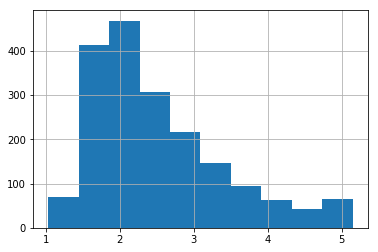

In [72]:
#Kullback-Leiber histogram
%matplotlib inline
KL["KL"].hist()
print "Mean: " + str(KL["KL"].mean())

In [73]:
KL.to_csv("../../KL_evaluation/kl_evaluation_PageRank_item_based.csv")

In [74]:
output=pd.DataFrame(index=pred_df.index, columns=["TOP", "values", "real_TOP", "real_values", "real_#"])
for user in pred_df.index:
    output["TOP"][user]=pred_df.loc[user].sort_values(ascending=False).index.tolist()
    output["values"][user]=pred_df.loc[user].sort_values(ascending=False).tolist()
    output["real_#"][user]=ratings.loc[user][area_colnames][ratings.loc[user][area_colnames]!=0.0].count()
    output["real_TOP"][user]=ratings.loc[user][area_colnames][ratings.loc[user][area_colnames]!=0.0].sort_values(ascending=False).index.tolist()
    output["real_values"][user]=ratings.loc[user][area_colnames][ratings.loc[user][area_colnames]!=0.0].sort_values(ascending=False).tolist()

In [75]:
output.to_csv("../../Output/output_PageRank_item_based.csv")

In [76]:
output.head()

,TOP,values,real_TOP,real_values,real_#
Cliente,,,,,
95,"[A342, A341, A296, A340, A297, A304, A242, A27...","[0.00612054765626, 0.00608504721028, 0.0060647...","[A225, A210, A275, A272, A195, A234, A280, A35...","[0.216, 0.064, 0.06, 0.06, 0.048, 0.044, 0.036...",48
10131,"[A271, A226, A220, A342, A218, A296, A315, A22...","[0.00601941130998, 0.00600320337171, 0.0060007...","[A210, A236, A225, A207, A289, A230, A311, A16...","[0.119932432432, 0.114864864865, 0.04898648648...",56
10188,"[A254, A280, A289, A156, A246, A308, A233, A24...","[0.00602237692556, 0.00601688113606, 0.0060164...","[A210, A205, A236, A289, A143, A207, A145, A31...","[0.114285714286, 0.0833333333333, 0.0642857142...",55
10262,"[A280, A242, A226, A248, A259, A228, A344, A31...","[0.00601624553198, 0.00601325941506, 0.0060124...","[A210, A311, A289, A312, A226, A166, A205, A16...","[0.198630136986, 0.109589041096, 0.08219178082...",32
10362,"[A207, A172, A254, A206, A212, A253, A171, A14...","[0.00604972037073, 0.00604394850977, 0.0060384...","[A143, A289, A205, A166, A207, A230, A210, A16...","[0.15595463138, 0.0812854442344, 0.06710775047...",91


In [77]:
#Recommendations output
recommendations=pd.DataFrame(index=pred_df.index, columns=["TOP12", "values"])
for user in pred_df.index:
    recommendations["TOP12"][user]=pred_df.loc[user][list(set(output["TOP"][user])-set(output["real_TOP"][user]))].sort_values(ascending=False).index.tolist()[:12]
    recommendations["values"][user]=pred_df.loc[user][list(set(output["TOP"][user])-set(output["real_TOP"][user]))].sort_values(ascending=False).tolist()[:12]

In [78]:
recommendations.to_csv("../../Recommendations/recommendations_PageRank_item_based.csv")

In [79]:
recommendations.head()

,TOP12,values
Cliente,,
95,"[A296, A340, A297, A242, A259, A241, A245, A33...","[0.00606473682753, 0.00604573125104, 0.0060285..."
10131,"[A271, A220, A342, A315, A242, A307, A250, A22...","[0.00601941130998, 0.00600070014759, 0.0060003..."
10188,"[A254, A280, A156, A246, A308, A233, A247, A26...","[0.00602237692556, 0.00601688113606, 0.0060158..."
10262,"[A280, A242, A248, A259, A228, A344, A315, A27...","[0.00601624553198, 0.00601325941506, 0.0060122..."
10362,"[A172, A254, A253, A168, A176, A292, A260, A19...","[0.00604394850977, 0.00603840954595, 0.0060309..."


In [80]:
%store df
%store families
%store ratings
%store ratings_train
%store ratings_test
%store train
%store test
%store pr_sim
%store pred_df
%store output
%store recommendations

Stored 'df' (DataFrame)
Stored 'families' (DataFrame)
Stored 'ratings' (DataFrame)
Stored 'ratings_train' (DataFrame)
Stored 'ratings_test' (DataFrame)
Stored 'train' (DataFrame)
Stored 'test' (DataFrame)
Stored 'pr_sim' (DataFrame)
Stored 'pred_df' (DataFrame)
Stored 'output' (DataFrame)
Stored 'recommendations' (DataFrame)


In [81]:
print("Total time in minutes: " + str((time.time() - global_time)/60.0))

Total time in minutes: 120.577989884
